<a href="https://colab.research.google.com/github/Hemaatchu/-Implementation-of-Logistic-Regression-Using-Gradient-Descent/blob/main/Deep_learning_WS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv('income.csv')

In [2]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [3]:
df['label'].value_counts()

,count
label,
0,21700
1,8300


In [4]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [5]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [6]:
for col in cat_cols:
    df[col] = df[col].astype('category')
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


In [7]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
print(emb_szs)

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]


In [8]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
cats[:5]

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

In [9]:
cats = torch.tensor(cats, dtype=torch.int64)
print(cats[:5])

tensor([[ 0, 10,  3,  2,  6],
        [ 0, 12,  1,  4,  7],
        [ 1, 13,  0,  2,  0],
        [ 1, 10,  1,  2,  1],
        [ 0, 13,  3,  2,  9]])


In [10]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts[:5]

array([[23, 50],
       [37, 39],
       [34, 40],
       [31, 40],
       [20, 25]])

In [11]:
conts = torch.tensor(conts, dtype=torch.float32)
print(conts.dtype)

torch.float32


In [12]:
y = torch.tensor(df[y_col].values, dtype=torch.int64).flatten()

In [13]:
b = 30000
t = 5000

cat_train = cats[:b-t]
cat_test = cats[b-t:]
con_train = conts[:b-t]
con_test = conts[b-t:]
y_train = y[:b-t]
y_test = y[b-t:]

In [14]:
import torch
import torch.nn as nn

class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni, nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [15]:
torch.manual_seed(33)

In [16]:
model = TabularModel(emb_szs=emb_szs, n_cont=len(cont_cols), out_sz=2, layers=[50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)

    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 0.81344783
epoch:  26  loss: 0.59463948
epoch:  51  loss: 0.51533115
epoch:  76  loss: 0.46403250
epoch: 101  loss: 0.42922997
epoch: 126  loss: 0.40061480
epoch: 151  loss: 0.37124151
epoch: 176  loss: 0.35842976
epoch: 201  loss: 0.34800136
epoch: 226  loss: 0.33588770
epoch: 251  loss: 0.33126819
epoch: 276  loss: 0.32283735
epoch: 300  loss: 0.31733111

Duration: 29 seconds


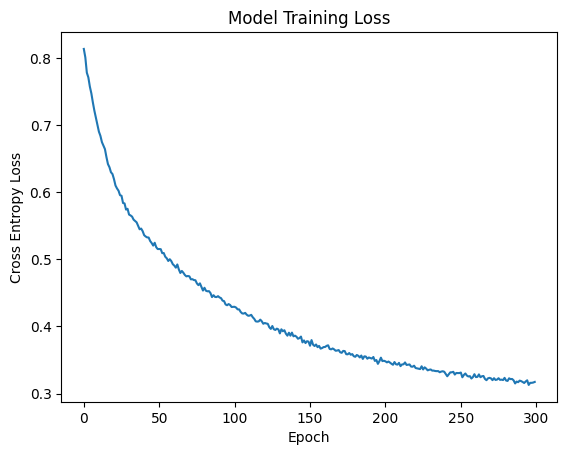

In [19]:
losses = [l.item() if torch.is_tensor(l) else l for l in losses]
plt.plot(np.array(losses, dtype=float))
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Model Training Loss")
plt.show()

In [20]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.33357456


In [21]:
correct = 0
for i in range(len(y_test)):
    if torch.argmax(y_val[i]).item() == y_test[i].item():
        correct += 1
print(f"{correct} out of {len(y_test)} = {100 * correct / len(y_test):.2f}% correct")

4229 out of 5000 = 84.58% correct


In [22]:
def predict_income(model, encoders, cont_inputs, cat_inputs):
    model.eval()
    cat_tensor = torch.tensor([cat_inputs], dtype=torch.int64)
    cont_tensor = torch.tensor([cont_inputs], dtype=torch.float32)
    with torch.no_grad():
        output = model(cat_tensor, cont_tensor)
        pred = torch.argmax(output, dim=1).item()
    return pred

In [23]:
sex_d = {'Female': 0, 'Male': 1}
education_d = {
    '3': 0, '4': 1, '5': 2, '6': 3, '6': 4, '8': 5, '12': 6,
    'HS-grad': 7, 'Some-college': 8, 'Assoc-voc': 9, 'Assoc-acdm': 10, 'Bachelors': 11,
    'Masters': 12, 'Prof-school': 13, 'Doctorate': 14
}
marital_d = {'Divorced': 0, 'Married': 1, 'Married-spouse-absent': 2, 'Never-married': 3, 'Separated': 4, 'Widowed': 5}
workclass_d = {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp': 3, 'State-gov': 4}
occupation_d = {'Adm-clerical': 0, 'Craft-repair': 1, 'Farming-fishing': 2, 'Handlers-cleaners': 3,
                'Machine-op-inspct': 4, 'Other-service': 5, 'Prof-specialty': 6, 'Protective-serv': 7,
                'Sales': 8, 'Tech-support': 9, 'Transport-moving': 10}

age = int(input("What is the person's age? (18-90) "))
sex = sex_d[input("What is the person's sex? (Male/Female) ").capitalize()]
education = education_d[input("What is the person's education level? ").strip()]
marital = marital_d[input("What is the person's marital status? ").strip()]
workclass = workclass_d[input("What is the person's workclass? ").strip()]
occupation = occupation_d[input("What is the person's occupation? ").strip()]
hours_per_week = int(input("How many hours/week are worked? (20-90) "))

cat_inputs = [sex, education, marital, workclass, occupation]
cont_inputs = [age, hours_per_week]

predicted_label = predict_income(model, None, cont_inputs, cat_inputs)

print(f"\nThe predicted label is {predicted_label}")

What is the person's age? (18-90) 35
What is the person's sex? (Male/Female) Male
What is the person's education level? Masters
What is the person's marital status? Married
What is the person's workclass? Private
What is the person's occupation? Sales
How many hours/week are worked? (20-90) 36

The predicted label is 1
